In [41]:
# 0. Import

import pandas as pd
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [42]:
# visualization settings

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pl.rcParams["savefig.dpi"]    = 1000
pl.rcParams["figure.figsize"] = [3, 3]

## 1. Load gene expression data generated by BoolODE

In [43]:
data = pd.read_csv(r'Fig2_data.csv', index_col=0, header=0)
data = np.transpose(data)

In [44]:
# create an anndata object
counts = csr_matrix(data, dtype=np.float64)
adata  = ad.AnnData(counts)

In [45]:
adata.obs_names = list(data.index)
adata.var_names = list(data.columns)
print(adata.obs_names[:10])
print(adata.var_names[:14])

Index(['E0_204', 'E1_25', 'E2_39', 'E3_118', 'E4_442', 'E5_747', 'E6_555',
       'E7_22', 'E8_154', 'E9_395'],
      dtype='object')
Index(['gA', 'gB', 'gC', 'gC1', 'gC2', 'gD', 'gD1', 'gD2', 'gE', 'gE1', 'gE2',
       'gF', 'gF1', 'gF2'],
      dtype='object')


In [46]:
adata.to_df()

,gA,gB,gC,gC1,gC2,gD,gD1,gD2,gE,gE1,gE2,gF,gF1,gF2
E0_204,1.716691,0.013065,0.031652,0.016390,0.010169,1.892850,1.699206,0.826867,0.013168,0.011413,0.020520,0.037346,0.001263,0.002785
E1_25,0.540377,0.298638,0.984022,0.001267,0.045800,1.259404,0.040039,0.005909,1.056375,0.003145,0.009186,0.942951,0.012440,0.007419
E2_39,0.007194,0.867029,0.183959,0.023549,0.009359,0.071549,0.000030,0.023861,0.797962,0.045629,0.000464,0.928544,0.069063,0.011947
E3_118,2.231369,0.003279,1.912061,1.569380,1.160495,0.492189,0.093263,0.066534,0.027048,0.004595,0.004478,0.066381,0.062844,0.025197
E4_442,2.267254,0.000016,0.034539,0.004053,0.018282,1.941269,0.064740,2.225046,0.015103,0.005021,0.008135,0.001603,0.000405,0.018060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2995_179,0.048628,1.953370,0.003294,0.002944,0.012875,0.020866,0.000055,0.049176,0.201908,0.010956,0.005765,2.203786,1.569260,1.170284
E2996_55,1.895044,0.004555,1.731787,0.000249,0.001349,1.963459,0.095719,0.012125,0.129646,0.006384,0.000746,0.052626,0.004902,0.011285
E2997_172,2.220843,0.012396,1.609257,0.575485,1.685097,0.098887,0.134354,0.386000,0.013060,0.036877,0.000260,0.003540,0.003903,0.013644
E2998_181,0.003355,2.010651,0.043247,0.040787,0.016696,0.004084,0.011328,0.002672,1.321871,2.022334,0.974227,0.015411,0.080258,0.022341


## 2. Clustering

In [47]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=40)
sc.tl.draw_graph(adata)

c:\users\seyed_000\appdata\local\programs\python\python38\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


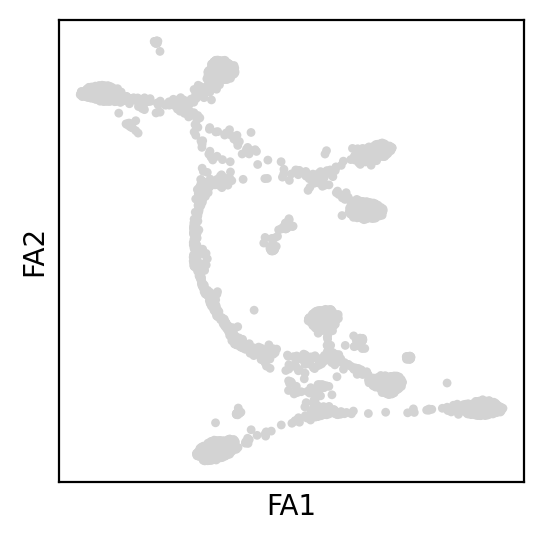

In [48]:
sc.pl.draw_graph(adata, legend_loc='on data')

In [49]:
## Louvain clustering
sc.tl.louvain(adata, resolution=2)

In [50]:
# Store the counts as a separate layer
adata.layers["counts"] = adata.X.copy()

In [51]:
adata

AnnData object with n_obs × n_vars = 3000 × 14
    obs: 'louvain'
    uns: 'neighbors', 'draw_graph', 'louvain'
    obsm: 'X_draw_graph_fa'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## 3. tSNE fitting

In [52]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.scale(adata, max_value=10)

In [53]:
sc.tl.tsne(adata, perplexity=800)

c:\users\seyed_000\appdata\local\programs\python\python38\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


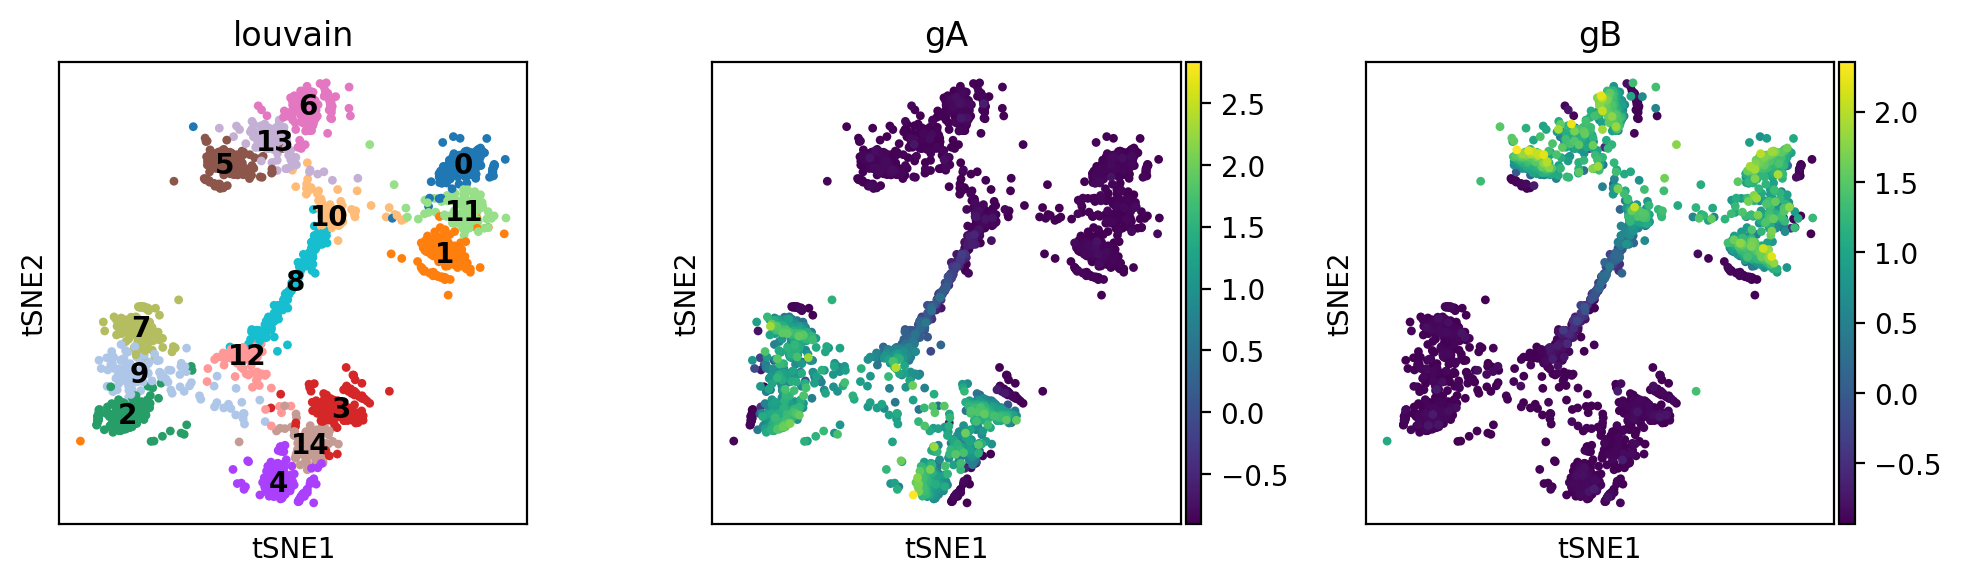

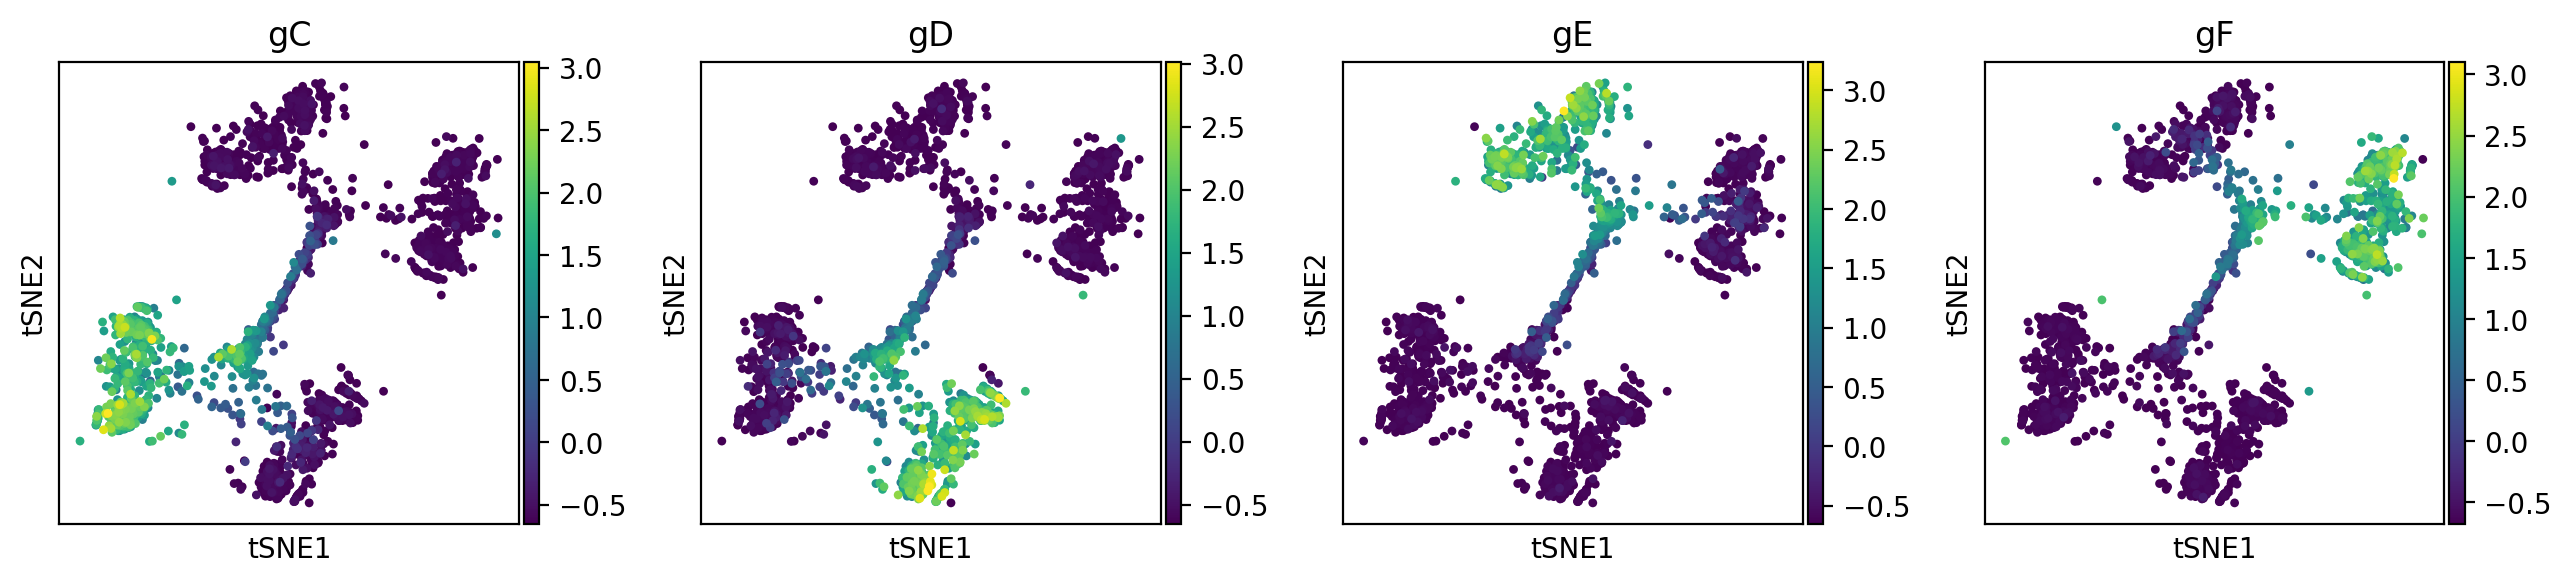

In [54]:
sc.pl.tsne(adata, color=['louvain','gA', 'gB'], legend_loc='on data')
sc.pl.tsne(adata, color=['gC', 'gD', 'gE', 'gF'], legend_loc='on data')

## 4. Pseudotime calculation

In [56]:
# Reconstructing gene changes along differentiation trajectory for a given set of genes
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain']  == '8')[0]

In [57]:
sc.tl.dpt(adata)

In [58]:
adata

AnnData object with n_obs × n_vars = 3000 × 14
    obs: 'louvain', 'dpt_pseudotime'
    var: 'mean', 'std'
    uns: 'neighbors', 'draw_graph', 'louvain', 'pca', 'tsne', 'louvain_colors', 'iroot', 'diffmap_evals'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

c:\users\seyed_000\appdata\local\programs\python\python38\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


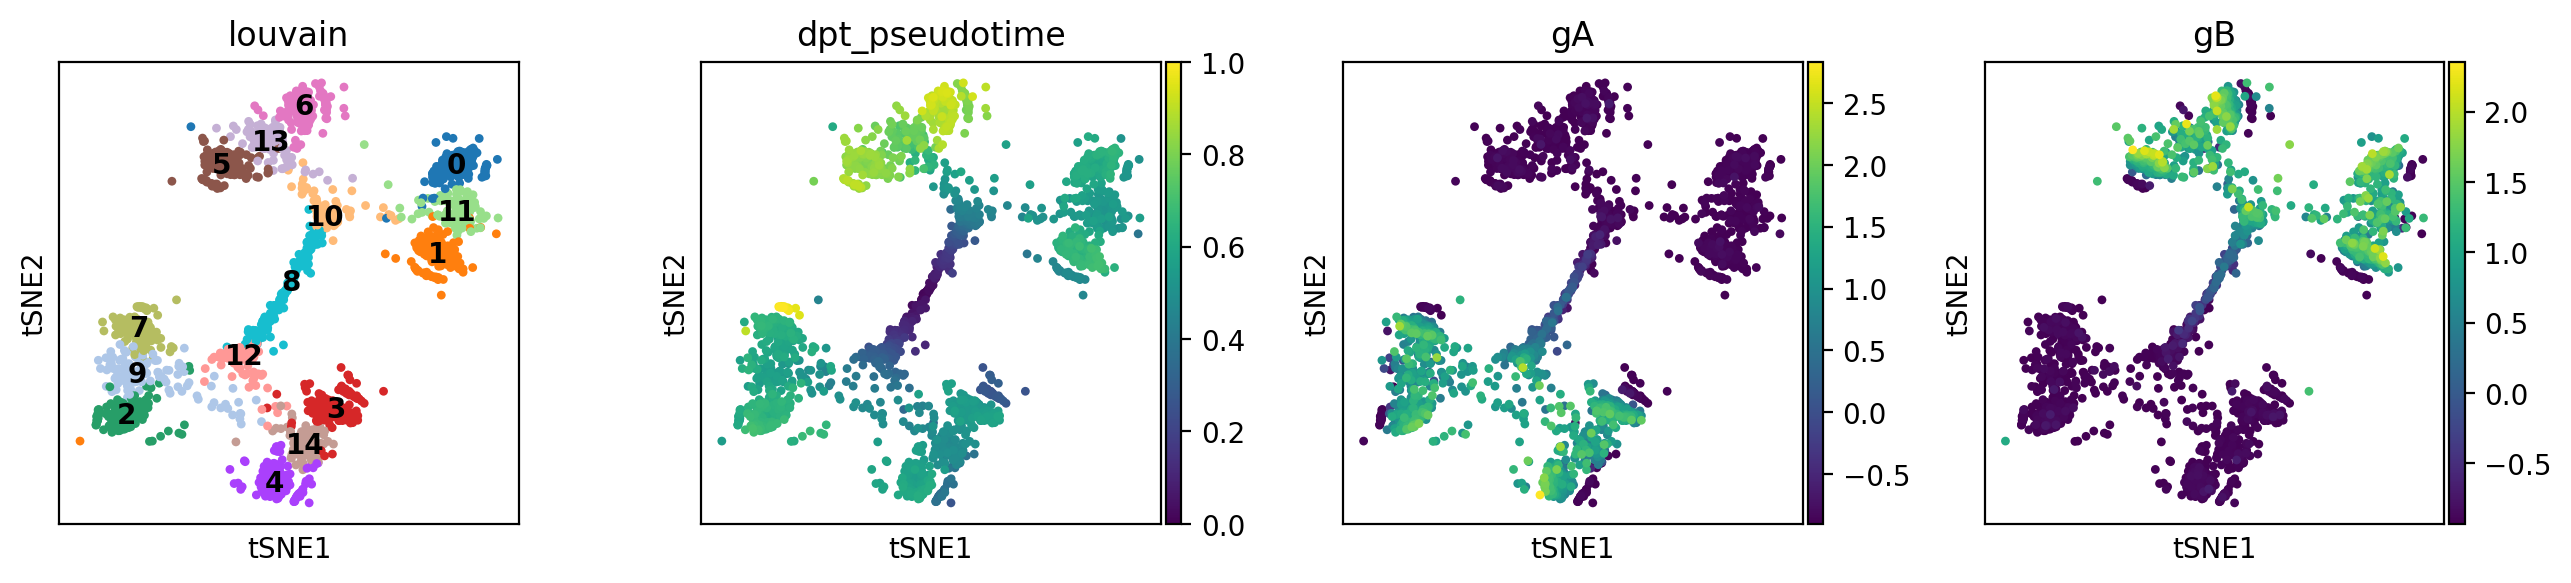

In [59]:
sc.pl.tsne(adata, color=['louvain', 'dpt_pseudotime', 'gA', 'gB'], legend_loc='on data')

## 5. Export data for Clusters I and II

In [60]:
adata.X = adata.layers["counts"].copy()

In [61]:
adata

AnnData object with n_obs × n_vars = 3000 × 14
    obs: 'louvain', 'dpt_pseudotime'
    var: 'mean', 'std'
    uns: 'neighbors', 'draw_graph', 'louvain', 'pca', 'tsne', 'louvain_colors', 'iroot', 'diffmap_evals'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_diffmap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [62]:
gene_names = adata.var_names 
print(gene_names)
  
paths = [('ClusterI'  , [5,6,13,0,1,11]),
         ('ClusterII' , [2,7,9,3,4,14 ]),
         ('stem_cells'     , [ 8])]
adata.obs['distance'] = adata.obs['dpt_pseudotime']
adata.obs['clusters'] = adata.obs['louvain']  # just a cosmetic change
!mkdir write_fig2

Index(['gA', 'gB', 'gC', 'gC1', 'gC2', 'gD', 'gD1', 'gD2', 'gE', 'gE1', 'gE2',
       'gF', 'gF1', 'gF2'],
      dtype='object')


c:\users\seyed_000\appdata\local\programs\python\python38\lib\site-packages\scanpy\plotting\_tools\paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
c:\users\seyed_000\appdata\local\programs\python\python38\lib\site-packages\scanpy\plotting\_tools\paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


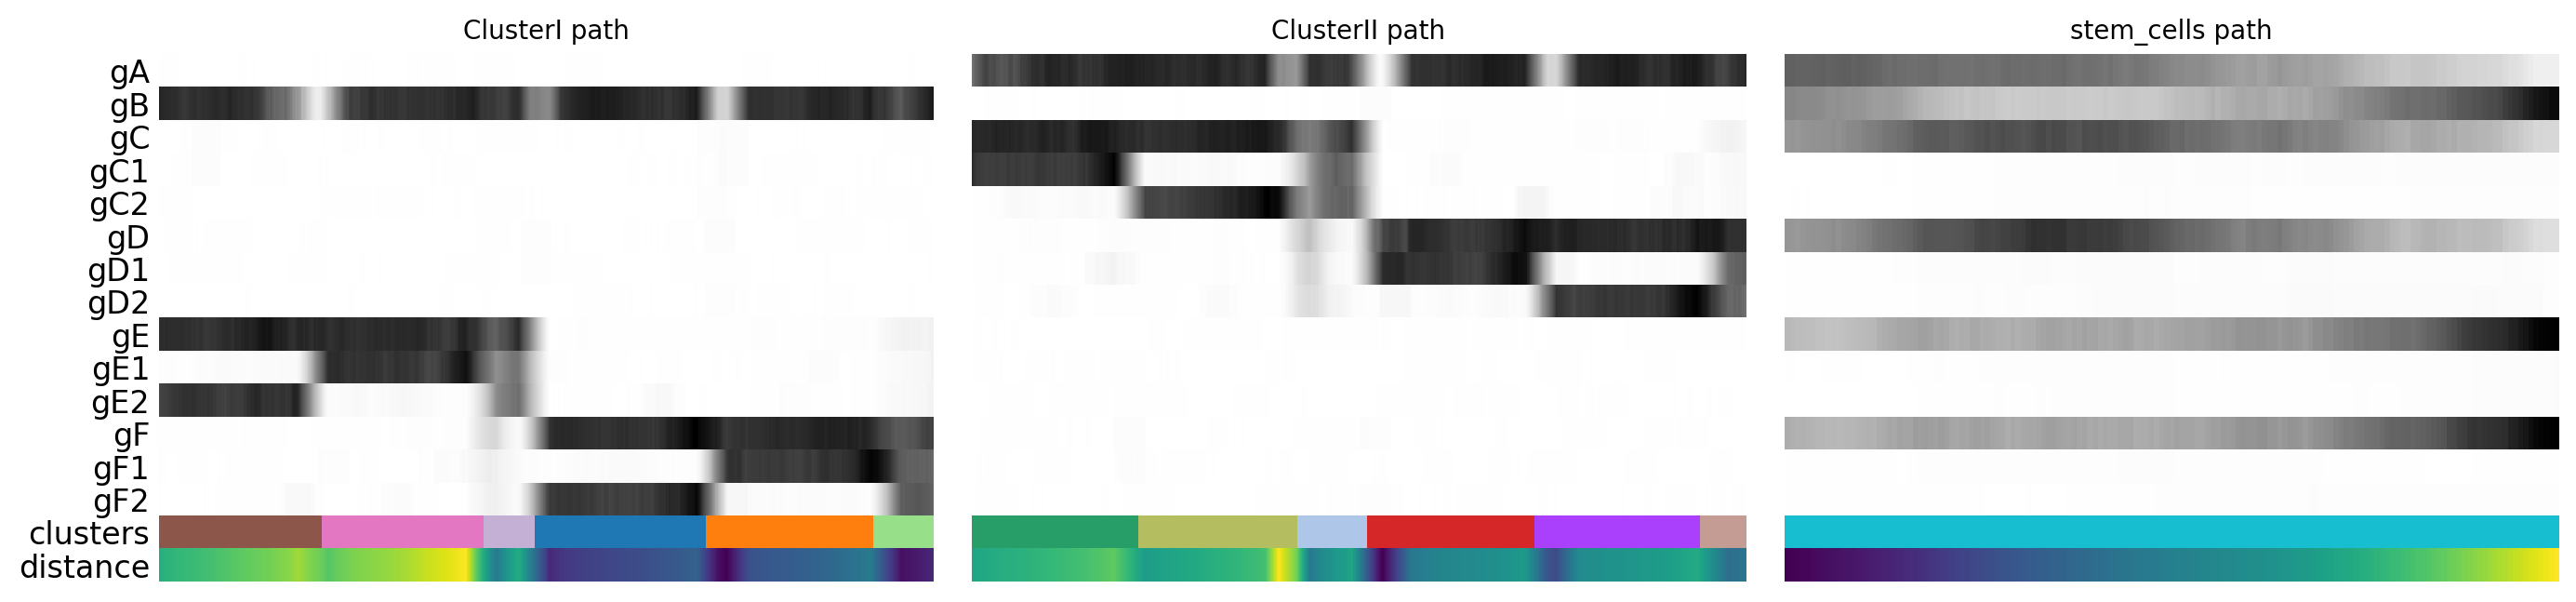

In [64]:
_, axs = pl.subplots(ncols=3, figsize=(15, 4), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write_fig2/{}.csv'.format(descr))
pl.savefig('./write_fig2/toggle_boolode.pdf')
pl.show()